In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

# Input data

In [2]:
data = pandas.read_csv('input.csv', index_col=False)

data.head()

,event,particle,hit,x,y
0,0,10000100,100000640,247.365072,968.954400
1,0,10000100,100000830,494.712256,1937.881317
2,0,10000100,100001150,742.059440,2906.808234
3,0,10000100,100000010,989.406625,3875.735151
4,0,10000100,100000560,1236.753809,4844.662068


# Hough Transform Modification

In [3]:
from hough import Hough
from regression import TrackRegression

class ModifiedHough(Hough):
    
    def new_track_inds(self, track_inds, n_hits):

        used = numpy.zeros(n_hits)
        new_track_inds = []


        while 1:

            track_lens = numpy.array([len(i[used[i] == 0]) for i in track_inds])
            
            if len(track_lens) == 0:
                break
                
            max_len = track_lens.max()

            if max_len < self.min_hits:
                break

            one_track_inds = track_inds[track_lens == track_lens.max()][0]
            one_track_inds = one_track_inds[used[one_track_inds] == 0]

            used[one_track_inds] = 1
            new_track_inds.append(numpy.array(one_track_inds))

        return numpy.array(new_track_inds)
    
    def new_track_params(self, track_inds, x, y):
        
        new_track_params = []
        
        for track in track_inds:
            
            tr = TrackRegression()
            tr.fit(x[track], y[track])
            
            new_track_params.append([tr.theta_, tr.invr_])
            
        return numpy.array(new_track_params)

    
    def predict(self, x, y): # This method must be!
        
        Hough.predict(self, x, y)
        
        self.track_inds_ = self.new_track_inds(self.track_inds_, len(x)) # This attribute must be!
        self.track_params_ = self.new_track_params(self.track_inds_, x, y) # This attribute is optional

## One event

In [4]:
toy_event_id = 0
event = data[data.event.values == toy_event_id]

In [5]:
from hough import Hough

h = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=400., min_hits=6)
h.predict(event.x.values, event.y.values)

matrix_hough = h.matrix_hough_
track_inds = h.track_inds_
track_params = h.track_params_

In [6]:
print "List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks."
track_inds

List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks.


array([array([16, 17, 18, 19, 20, 21, 22, 23, 59]),
       array([  0,   1,   2,   3,   4,   5,   6,   7, 100]),
       array([64, 65, 66, 67, 68, 69, 70, 71, 78]),
       array([40, 41, 42, 43, 44, 45, 46, 47]),
       array([24, 25, 26, 27, 28, 29, 30, 31]),
       array([112, 113, 114, 115, 116, 117, 118, 119]),
       array([80, 81, 82, 83, 84, 85, 86, 87]),
       array([ 8,  9, 10, 11, 12, 13, 14, 15]),
       array([32, 33, 34, 35, 36, 37, 38, 39]),
       array([104, 105, 106, 107, 108, 109, 110, 111]),
       array([48, 49, 50, 51, 52, 53, 54, 55]),
       array([88, 89, 90, 91, 92, 93, 94, 95]),
       array([72, 73, 74, 75, 76, 77, 79]),
       array([56, 57, 58, 60, 61, 62, 63]),
       array([ 96,  97,  98,  99, 101, 102, 103])], dtype=object)

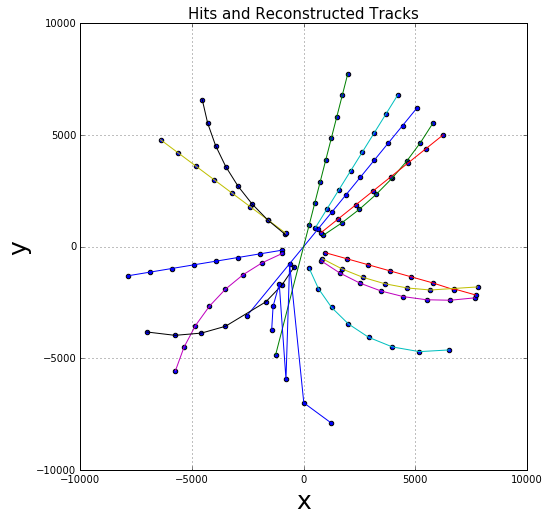

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(event.x.values, event.y.values)

for track in track_inds:
    
    xs = event.x.values[track]
    ys = event.y.values[track]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Reconstructed Tracks", size=15)
plt.xlabel("x", size=25)
plt.ylabel("y", size=25)
plt.grid(b=1)
plt.show()

In [8]:
track_params

array([[  2.45556436e+00,   3.43875510e-07],
       [  2.89004877e+00,   7.10356645e-07],
       [  4.44774161e+00,   4.21584774e-06],
       [  1.59683455e-01,   1.78288375e-04],
       [  8.31763492e-01,   1.08269148e-04],
       [  9.29312829e-01,   1.55359343e-09],
       [  1.03848807e+00,   1.05249149e-04],
       [  1.73543774e+00,   8.18310528e-09],
       [  2.05872307e+00,   6.76872148e-05],
       [ -8.95556620e-01,   1.24655614e-09],
       [ -5.55415767e-01,   8.68024384e-09],
       [ -1.32378326e+00,   1.24762135e-04],
       [  9.48046653e-01,   9.61801928e-05],
       [  2.79181522e+00,   1.65298233e-04],
       [ -7.80518216e-01,   2.01243536e-04]])

## Several events

**TrackRecognizer** is used to recognize tracks in several events using a track pattern recognition method. The method should has the following structure:

In [9]:
class Method(object):
    
    def __init__(self, params):
        
        # You code
        
        pass
    
    def predict(self, x, y):
        
        # Your code
        
        self.track_inds_

In [10]:
from recognizer import TrackRecognizer

method = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=400., min_hits=6)

tr = TrackRecognizer(method=method)
results = tr.predict(data)

results.head()

,event,track,hit,x,y
0,0,0,100000550,632.860081,774.256419
1,0,0,100001090,1265.733776,1548.511471
2,0,0,100000320,1898.607472,2322.766523
3,0,0,100001370,2531.481167,3097.021575
4,0,0,100000300,3164.354863,3871.276627


## Quality metrics

In [11]:
from metrics import RecognitionQuality

rq = RecognitionQuality(data, results, track_eff_threshold=0.8, min_hits_per_track=6)
report_event, report_tracks = rq.calculate()

In [12]:
report_event.head()

,Event,ReconstructionEfficiency,GhostRate,CloneRate,AvgTrackEfficiency
0,0,1.000000,0.000000,0,0.977778
1,1,1.000000,0.000000,0,1.000000
2,2,0.857143,0.071429,0,0.942308
3,3,1.000000,0.000000,0,0.957465
4,4,0.857143,0.071429,0,0.953380


In [13]:
report_event.mean(axis=0)

Event                       99.500000
ReconstructionEfficiency     0.981688
GhostRate                    0.010356
CloneRate                    0.000000
AvgTrackEfficiency           0.979373
dtype: float64

In [14]:
report_tracks.head()

,Event,Track,TrackEfficiency
0,0,0,0.888889
1,0,1,0.888889
2,0,2,0.888889
3,0,3,1.000000
4,0,4,1.000000
